# Статистический анализ данных сервиса аренды самокатов

## Бибилиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st 

## Первый взгляд на данные

In [2]:
users = pd.read_csv(r'D:\Analysis\repository_prakticum\users_go.csv')
rides = pd.read_csv(r'D:\Analysis\repository_prakticum\rides_go.csv', parse_dates=['date'])
subscriptions = pd.read_csv(r'D:\Analysis\repository_prakticum\subscriptions_go.csv')

### Пользователи

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


*Комментарий.* Таблица содержит 5 столбцов и 1565 строк. Типы данных (int, object) соответствуют содержащейся в ячейках информации. Пропуски отсутствуют.

### Поездки

In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


*Комментарий.* Таблица содержит 4 столбца и 18068 строк. Типы данных (int, float, datetime) соответствуют содержащейся в ячейках информации. Пропуски отсутствуют.

### Подписка

In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


*Комментарий.* Таблица содержит 4 столбца и 2 строки. Типы данных (int, object) соответствуют содержащейся в ячейках информации. Пропуски отсутствуют.

### Предобработка данных

#### Дубликаты

In [9]:
#Проверим данные на наличие дубликатов.
print('Количество дубликатов в таблице users -', users.duplicated().sum())
print('Количество дубликатов в таблице rides -', rides.duplicated().sum())
print('Количество дубликатов в таблице subscriptions -', subscriptions.duplicated().sum())

Количество дубликатов в таблице users - 31
Количество дубликатов в таблице rides - 0
Количество дубликатов в таблице subscriptions - 0


Нас интересуют только уникальные пользователи. Удалим дубликаты из таблицы users:
- Сохраним количество строк исходного датафрейма для оценки доли удаленных данных здесь и далее, если необходимо.
- Удалим дубликаты.
- Оценим сколько данных было удалено.

In [10]:
initial_users = len(users)
users = users.drop_duplicates()

print(f'Доля удаленных дубликатов от всех данных в таблицы users составила {(1-len(users)/initial_users):.2%}')

Доля удаленных дубликатов от всех данных в таблицы users составила 1.98%


Проверим названия городов на неявные дубликаты. Выведем список представленных городов.

In [11]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

В названиях городов неявных дубликатов нет. Всего представлено 8 городов.

#### Новые столбцы

Добавим столбец с номером месяца в rides для оценки ежемесячной активности.

In [12]:
rides['month']=rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


## Исследовательский анализ данных (EDA)
Общая информация о пользователях и поездках.

### Частота встречаемости городов

Посмотрим распределение пользователей по городам на графике.

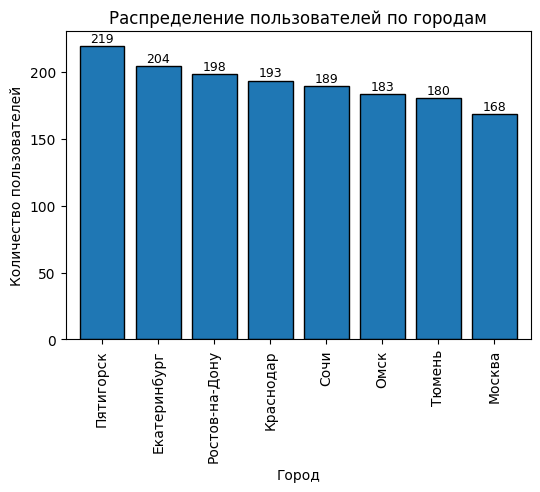

In [13]:
cities = users.groupby('city')['city'].count().sort_values(ascending=False)

ax = cities.plot.bar(width=0.8,
                     edgecolor='black',
                     grid=False,
                     figsize=(6, 4))

plt.title('Распределение пользователей по городам')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')

for i, v in enumerate(cities.values):
    ax.text(i, v + 1, f'{v}', ha='center', va='bottom', fontsize=9)

*Комментарий.* Представлены данные о пользователях из 8 городов: Пятигорск, Екатеринбург, Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень, Москва. Количество пользователей из разных городов варьируется от 219 в Пятигорске до 168 в Москве. 

### Соотношение пользователей c подпиской и без подписки

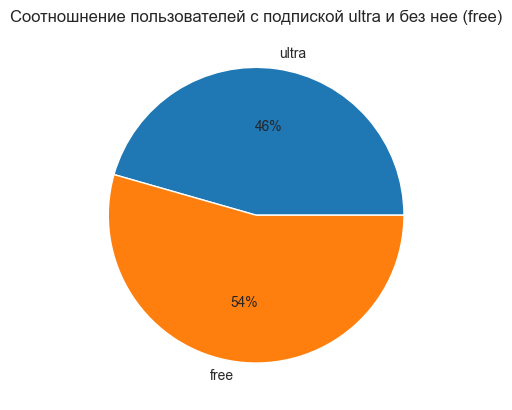

In [14]:
share_of_subscr = [users.query('subscription_type == "ultra"')['subscription_type'].count(),
                   users.query('subscription_type == "free"')['subscription_type'].count()]

name = ['ultra',
        'free']

sns.set_style('whitegrid')
plt.pie(share_of_subscr,
        labels=name,
        autopct='%1.0f%%')

plt.title('Соотношнение пользователей с подпиской ultra и без нее (free)');

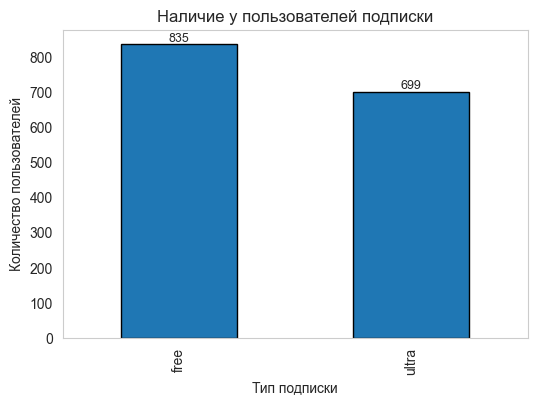

In [15]:
subscription_counts = users['subscription_type'].value_counts()

ax = subscription_counts.plot.bar(grid=False,
                                  figsize=(6, 4),
                                  edgecolor='black')

for i, v in enumerate(subscription_counts.values):
    ax.text(i, v + 1, f'{v}', ha='center', va='bottom', fontsize=9)

plt.title('Наличие у пользователей подписки')
plt.xlabel('Тип подписки')
plt.ylabel('Количество пользователей');

*Комментарий.* Количество пользователей с подпиской и без нее, представленных в данных, одного порядка. Тех, кто не пользуется подпиской немного больше: ultra:free=1:1,17.

### Возраст пользователей

Посмотрим как пользователи распределены по возрастам. Построим гистрограмму. Для уточнения количества корзин посмотрим разность в возрасте между самым старшим и самым младшим пользователем.

In [16]:
for_bins = users['age'].max()-users['age'].min()
for_bins

31

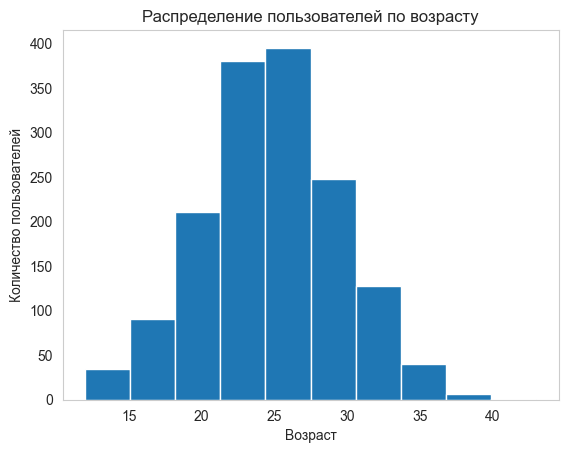

In [17]:
#Построим гистограммму, количество корзин примем равным 10.
users['age'].hist(bins=10,
                  grid=False)

plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей');

In [18]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

*Комментарий.* В основном сервисом аренды самокатов пользуются люди в возрасте 22-28 лет, средний (арифметический и медианный) возраст пользователя - 25 лет. Для этого параметра характерно нормальное распределение представленных в данных значений.

### Расстояние одной поездки пользователя

Посмотрим как распредлены расстояния поездок среди пользователей. Построим гистограмму.

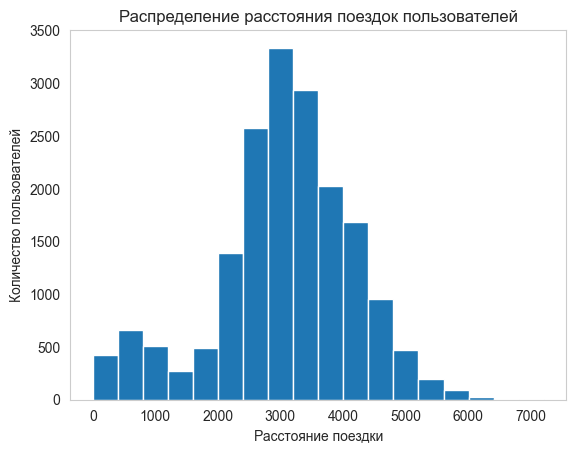

In [19]:
rides['distance'].hist(bins=18, grid=False)

plt.title('Распределение расстояния поездок пользователей')
plt.xlabel('Расстояние поездки')
plt.ylabel('Количество пользователей');

*Комментарий.* Распределение расстояния поездки каждого пользователя имеет два максимума: 1) поездки на расстояние около 500 м совершили чуть больше 500 пользователей. 2) Чаще всего (около 3250 поездок) пользователи совершают поездки на расстояние 3000 м.

### Продолжительность поездок

Аналогично предыдущему подпункту оценим продолжительность поездок.

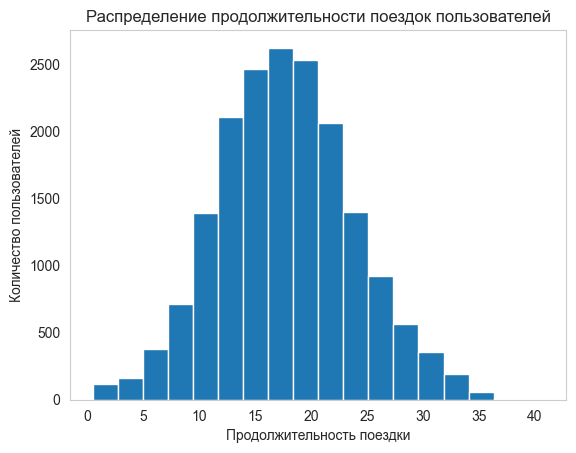

In [20]:
rides['duration'].hist(bins=18, grid=False)

plt.title('Распределение продолжительности поездок пользователей')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество пользователей');

*Комментарий.* Распределение продолжительности поездок пользователей подчиняется нормальному распределению. Чаще всего пользователи проводят в пути около 18 минут.

## Статистический анализ 

### Расстояние и время поездок в разрезе типа подписки

#### Объединение всех данных в одну таблицу

Таблицы users и rides объединим по общему полю user_id. Таблицу subscriptions присоеденим по общему полю subscription_type.

In [21]:
merged_data = pd.merge(users, rides, on='user_id', how='inner')
merged_data = pd.merge(merged_data, subscriptions, on='subscription_type', how='inner')

merged_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


*Комментарий.* Объединенный датафрейм содержит всю известную информацию для каждого пользователя.

#### Создание датафреймов по типу подписки

В дальнейшем будем рассматривать пользователей с подпиской ultra и без нее (free) по отдельности. Для этого создадим два новых датафрейма на основе объединенных в предыдущем подпункте данных merged_data.

##### С данным о пользователях с подпиской ultra

In [22]:
subscr = merged_data.loc[merged_data['subscription_type'] == 'ultra'].copy()
subscr['subscription_type'].unique()

array(['ultra'], dtype=object)

In [23]:
subscr.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


##### С данными о пользователях без подписки (free)

In [24]:
no_subscr = merged_data.loc[merged_data['subscription_type'] != 'ultra'].copy()
no_subscr['subscription_type'].unique()

array(['free'], dtype=object)

In [25]:
no_subscr.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


Проверим все ли данные вошли в новые датафреймы.

In [26]:
print('Разница между исходными данными и суммой 2 новых датафреймов составляет',
      len(merged_data)-(len(subscr)+len(no_subscr)), 'строк.')

Разница между исходными данными и суммой 2 новых датафреймов составляет 0 строк.


#### Расстояние и время поездок

Построим два подграфика с распределеним значений параметров 'distance' и 'duration' среди пользователей в разрезе выделенных на предыдущем шаге категорий, отражающих наличие подписки (subscr, no_subscr).

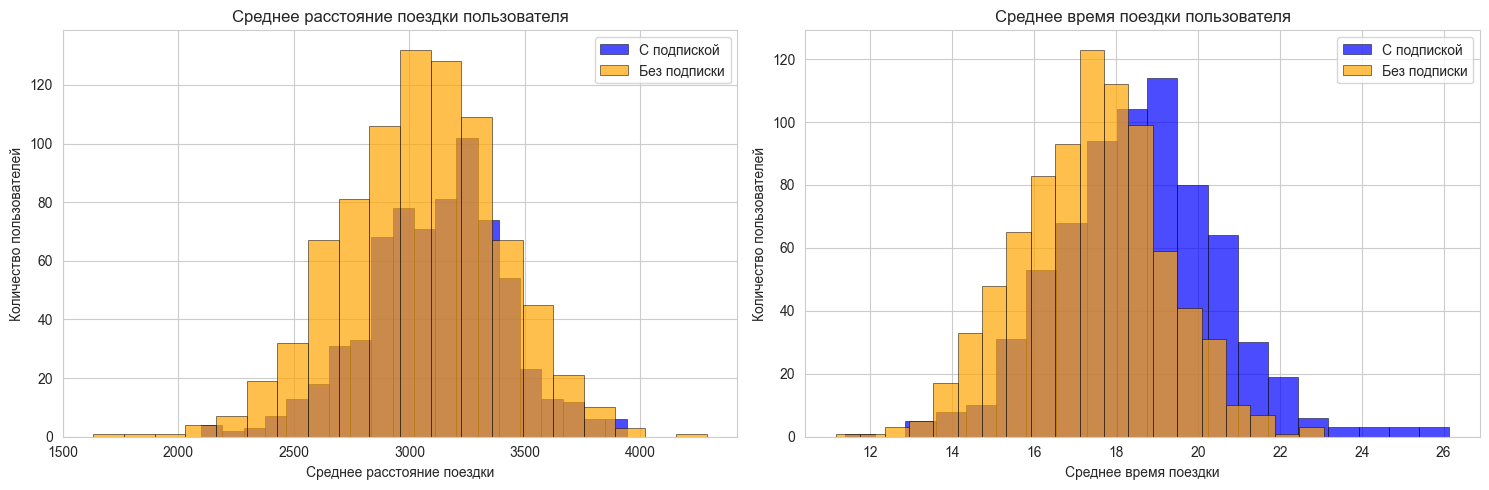

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма среднего расстояния.
subscr_dist = subscr.groupby('user_id')['distance'].mean()
no_subscr_dist = no_subscr.groupby('user_id')['distance'].mean()

ax1.hist(subscr_dist, bins=20, alpha=0.7, 
         label='С подпиской', color='blue', 
         edgecolor='black', linewidth=0.5)
ax1.hist(no_subscr_dist, bins=20, alpha=0.7, 
         label='Без подписки', color='orange', 
         edgecolor='black', linewidth=0.5)

ax1.set_title('Среднее расстояние поездки пользователя')
ax1.set_ylabel('Количество пользователей')
ax1.set_xlabel('Среднее расстояние поездки')
ax1.legend()

# Гистограмма среднего времени.
subscr_time = subscr.groupby('user_id')['duration'].mean()
no_subscr_time = no_subscr.groupby('user_id')['duration'].mean()

ax2.hist(subscr_time, bins=20, alpha=0.7, 
         label='С подпиской', color='blue', 
         edgecolor='black', linewidth=0.5)
ax2.hist(no_subscr_time, bins=20, alpha=0.7, 
         label='Без подписки', color='orange', 
         edgecolor='black', linewidth=0.5)

ax2.set_title('Среднее время поездки пользователя')
ax2.set_xlabel('Среднее время поездки')
ax2.set_ylabel('Количество пользователей')
ax2.legend()

plt.tight_layout();

*Комментарий.* Визуально распределения времени и расстояния близки к нормальному (меньше остальных близко распределение расстояния пользователей с подпиской).<br>Для пользователей с подпиской: характерное среднее расстояния поездки - 3300 м, время поездки - 19 мин.<br>Для пользователей без подписки: характерное расстояние поездки - 3000 м, время поездки - 18 мин.

### Подсчёт выручки

Создадим датафрейм с информацией о поездках и выручке для каждого пользователя за каждый месяц. Отразим следующую информацию: 
- суммарное расстояние,
- количество поездок,
- суммарное время (округлим в большую сторону до целого числа),
- выручку, которую принес пользователь.

#### Для пользователей с подпиской ultra

In [28]:
subscr.loc[:, 'duration'] =np.ceil(subscr['duration'])
subscr['duration'].head()

0    26.0
1    16.0
2     7.0
3    19.0
4    27.0
Name: duration, dtype: float64

In [29]:
agg_rides_subscr = (
    pd
    .pivot_table(data=subscr,
                index=['user_id', 'month'],
                values=['distance', 'name', 'duration'],
                aggfunc={'distance' : 'sum',
                        'name' : 'count',
                        'duration' : 'sum'})
    .rename(columns={'name' : 'rides_number'})
    .reset_index()
)

agg_rides_subscr.head()

,user_id,month,distance,duration,rides_number
0,1,1,7027.511294,42.0,2
1,1,4,754.159807,7.0,1
2,1,8,6723.470560,46.0,2
3,1,10,5809.911100,32.0,2
4,1,11,7003.499363,56.0,3


In [30]:
#Зададим стоимость услуг с подпиской.
ultra_start = subscriptions.query('subscription_type == "ultra"')['start_ride_price'].mean()
ultra_minute = subscriptions.query('subscription_type == "ultra"')['minute_price'].mean()
ultra_fee = subscriptions.query('subscription_type == "ultra"')['subscription_fee'].mean()

#Рассчитаем выручку.
agg_rides_subscr['revenue'] = (ultra_start*agg_rides_subscr['rides_number']
                        + ultra_minute*agg_rides_subscr['duration']
                        + ultra_fee)

agg_rides_subscr.head()

,user_id,month,distance,duration,rides_number,revenue
0,1,1,7027.511294,42.0,2,451.0
1,1,4,754.159807,7.0,1,241.0
2,1,8,6723.470560,46.0,2,475.0
3,1,10,5809.911100,32.0,2,391.0
4,1,11,7003.499363,56.0,3,535.0


#### Для пользователей без подписки

In [31]:
no_subscr.loc[:, 'duration'] =np.ceil(no_subscr['duration'])
no_subscr.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0


In [32]:
agg_rides_no_subscr = (
    pd
    .pivot_table(data=no_subscr,
                index=['user_id', 'month'],
                values=['distance', 'name', 'duration'],
                aggfunc={'distance' : 'sum',
                        'name' : 'count',
                        'duration' : 'sum'})
    .rename(columns={'name' : 'rides_number'})
    .reset_index()
)

agg_rides_no_subscr.head()

,user_id,month,distance,duration,rides_number
0,700,1,2515.690719,15.0,1
1,700,2,13446.659764,89.0,5
2,700,3,3798.334905,19.0,1
3,700,4,2984.551206,16.0,1
4,700,6,5927.650988,29.0,2


In [33]:
#Зададим стоимость услуг с подпиской.
free_start = subscriptions.query('subscription_type == "free"')['start_ride_price'].mean()
free_minute = subscriptions.query('subscription_type == "free"')['minute_price'].mean()

#Рассчитаем выручку.
agg_rides_no_subscr['revenue'] = (free_start*agg_rides_no_subscr['rides_number']
                        + free_minute*agg_rides_no_subscr['duration'])

agg_rides_no_subscr.head()

,user_id,month,distance,duration,rides_number,revenue
0,700,1,2515.690719,15.0,1,170.0
1,700,2,13446.659764,89.0,5,962.0
2,700,3,3798.334905,19.0,1,202.0
3,700,4,2984.551206,16.0,1,178.0
4,700,6,5927.650988,29.0,2,332.0


### Проверка гипотез 

#### Время поездки пользователя с подпиской

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

*Нулевая гипотеза.* 
- Среднее значение времени поездки для пользователей с подпиской и без нее равны.

*Альтернативная гипотеза.*
- Среднее значение времени поездки для пользователей с подпиской больше среднего времени поездки для пользователей без подписки.

*Проверка гипотезы.*
- Проведем односторонний t-тест для средних двух генеральных совокупностей. Поскольку выборки отличаются по размеру и нет уверенности, что дисперсия не будет отличаться, укажем условие equal_var=False. В качестве альтернативной гипотезы рассмотрим alternative='greater'.

In [34]:
alpha = 0.05  

res1 = st.ttest_ind(subscr['duration'], no_subscr['duration'], alternative='greater', equal_var=False)

print('p-значение:', res1.pvalue)

if res1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 


p-значение: 1.1814679253701353e-36
Отвергаем нулевую гипотезу


**Вывод:** Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки на самокате.

#### Среднее расстояние поездки

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

*Нулевая гипотеза.* 
- Среднее расстояние поездки для пользователей с подпиской равно 3130 метров.

*Альтернативная гипотеза.*
- Среднее расстояние поездки для пользователей с подпиской больше 3130 метров.

*Проверка гипотезы.*
- Проведем одновыборочный односторонний t-тест. В качестве альтернативной гипотезы рассмотрим alternative='greater'.

In [35]:
optimal_distance = 3130
alpha = 0.05

res2 = st.ttest_1samp(subscr['distance'], optimal_distance, alternative='greater')

print('p-значение:', res2.pvalue)

if res2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Вывод:** p-значение выше уровня значимости, нулевую гипотезу не отвергаем. Расстояние, которое проезжают пользователи с подпиской, равно оптимальному значению. Или иными словами не превышает его.

#### Помесячная выручка

Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

*Нулевая гипотеза.* 
- Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.

*Альтернативная гипотеза.*
- Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

*Проверка гипотезы.*
- Проведем односторонний t-тест для средних двух генеральных совокупностей. Поскольку выборки отличаются по размеру и нет уверенности, что дисперсия не будет отличаться, укажем условие equal_var=False. В качестве альтернативной гипотезы рассмотрим alternative='greater'.

In [36]:
alpha = 0.05  

res3 = st.ttest_ind(agg_rides_subscr['revenue'],
                    agg_rides_no_subscr['revenue'],
                    alternative='greater',
                    equal_var=False)

print('p-значение:', res3.pvalue)

if res3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


**Вывод:** Полученное значение p-value меньше заданного уровня значимости, различия между значениями статистически значимые. Это позволяет отвергнуть нулевую гипотезу и принять альтернативную, согласно которой помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

## Вывод

**Задача.** Проверка  гипотез, которые могут помочь бизнесу вырасти, а именно привлечь большее число пользователей с подпиской.<br>Для анализа были представлены данные о некоторых пользователях из нескольких городов, об их поездах для сервиса аренды самокатов. Чтобы совершать поездки по городу, пользователи сервиса используют мобильное приложение.<br>**Цель исследования:** проверить гипотезы о возможности большей выручки при масштабировании бизнеса путем привлечения большего числа пользователей с подпиской.

Перед анализом данные были обработаны:
1. Удалены дубликаты.
2. Добавлен столбец с месяцем каждой поездки.

<br>Исследователький анализ данных (EDA):
1. В данных представлена иноформация о пользователях из 8 городов: Пятигорск, Екатеринбург, Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень, Мосева. Количество пользователей из разных городов варьируется от 219 в Пятигорске до 168 в Москве.
2. Пользователи с подпской и без нее представлены в данных в близком количестве: ultra:free=1:1,17.
3. В основном сервисом аренды самокатов пользуются люди в возрасте 22-28 лет. Возраст пользователей имеет нормальное распределение.
4. Распределение расстояния поездки каждого пользователя имеет два максимума: 1) поездки на расстояние около 500 м совершили чуть больше 500 пользователей. 2) Чаще всего (около 3250 поездок) пользователи совершают поездки на расстояние 3000 м.
5. Распределение средней продолжительности поездки пользователя подчиняется нормальному распределению. Чаще всего в среднем пользователи проводят в пути около 18 минут.

<br>Статистический анализ:
1. Данные были объедены в один датафрейм, содержащий всю имеющуюся информацию о пользователях и их поездках. Далее данные были разделены на две выборки: с подписчиками сервиса и с пользователями без подписки. Среднее время поездки для пользователей можно описать нормальным распределением. Для пользователей с подпиской: характерное среднее расстояния поездки - 3300 м, время поездки - 19 мин. Для пользователей без подписки: характерное расстояние поездки - 3000 м, время поездки - 18 мин
2. Был произведен подсчет месячной выручки с каждого пользователя с подпиской и без.
3. Проведена статистическая проверка гипотез:
>- Проверена гипотеза о том, что среднее время поездки пользователей с подпиской выше, чем пользователей без подписки. Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки на самокате.
>- Проверена гипотеза о том, что среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстояние с точки зрения износа самоката (3130 метров). Расстояние, которое проезжают пользователи с подпиской, равно оптимальному значению. Или иными словами не превышает его.
>- Проверена гипотеза о том, что выручка среди пользователей с подпиской выше, чем среди пользователей без подписки. Есть основания утверждать, что гипотеза верна: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

<br>**Вывод:** На основе проведенных исследований и статистических тестов можно сказать, что привлечение большего количества клиентов с подпиской принесет больше выручки сервису аренды самокатов..

## Расчет вероятности успеха маркетинговых кампаний 

### Акция с раздачей промокодов

Отделу маркетинга необходимо провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.<br>
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей.

Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %:
- Определим функцию linespace(start, stop, num), которая создает список чисел для построения нормального приближения.
- Определим функцию min_promocodes(p, k, alpha, low, high) для поиска минимального числа промокодов (n_min), при котором вероятность не набрать k продлений — не выше alpha (5 %). Используем биноминальное распределение (st.binom.cdf(k−1, n, p) для вычисления P(X ≤ 99))
- Найдем наименьшее n, при котором P(X < 100) ≤ 5%.
- Визуализируем биноминальное распределение для найденного n_min в сравнении с нормальным приближением (используем linespace()).

Минимальное число промокодов: 1161
Вероятность НЕвыполнения плана: 4.98%
Вероятность выполнения плана: 95.02%


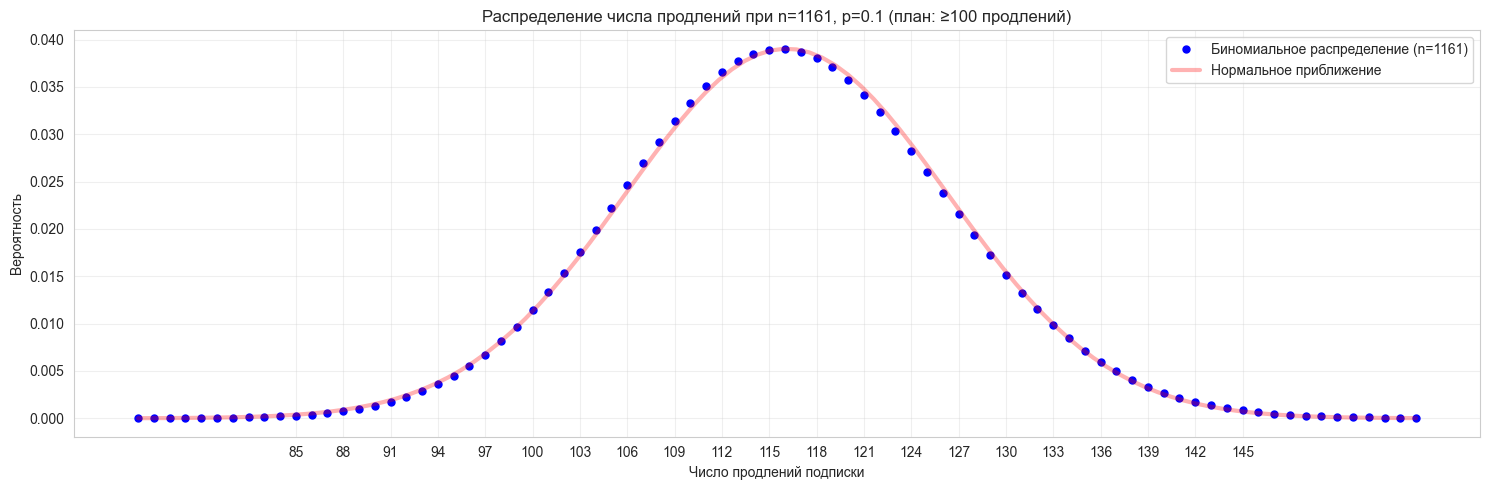

In [37]:
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

def min_promocodes(p, k, alpha, low=100, high=5000):
    while low < high:
        mid = (low + high) // 2
        fail_prob = st.binom.cdf(k - 1, mid, p)
        
        if fail_prob <= alpha:
            high = mid
        else:
            low = mid + 1
        
    final_fail_prob = st.binom.cdf(k - 1, low, p)
    return low, final_fail_prob

# Параметры задачи
p = 0.1           # вероятность продления после промокода
k = 100           # целевое число продлений (минимальный план)
alpha = 0.05      # допустимая вероятность НЕвыполнения плана (5%)

n_min, fail_prob = min_promocodes(p, k, alpha)

print(f'Минимальное число промокодов: {n_min}')
print(f'Вероятность НЕвыполнения плана: {fail_prob:.2%}')
print(f'Вероятность выполнения плана: {1 - fail_prob:.2%}')

# Визуализация для найденного n_min
if n_min:
    mu = n_min * p
    sigma = (n_min * p * (1 - p))**0.5
    left = int(mu - 4 * sigma)
    right = int(mu + 4 * sigma)
    x_binom = list(range(max(0, left), right + 1))

    plt.figure(figsize=(15, 5))
    ax = plt.subplot()

    # Биномиальное распределение
    ax.plot(x_binom, st.binom.pmf(x_binom, n_min, p), 'bo', ms=5,
             label=f'Биномиальное распределение (n={n_min})')

    # Нормальное приближение (для сравнения)
    x_norm = linspace(left, right, 100)
    ax.plot(x_norm, st.norm.pdf(x_norm, mu, sigma), 'r-', lw=3, alpha=0.3,
             label='Нормальное приближение')

    x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma) + 1, max(1, int(sigma//3))))
    ax.set_xticks(x_ticks)

    ax.legend(loc='best')
    plt.title(f'Распределение числа продлений при n={n_min}, p={p} (план: ≥{k} продлений)')
    plt.xlabel('Число продлений подписки')
    plt.ylabel('Вероятность')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('n не найдено.');

**Вывод:** <br>
По графику:
- Биномиальное распределение (синие точки) показывает точные вероятности для каждого количества продлений (от ~85 до ~145). Пик распределения находится около 116 продлений — это наиболее вероятный исход.
- Нормальное приближение (розовая линия) хорошо совпадает с биномиальным распределением, подтверждая корректность расчётов.

Таким образом, рассылка 1161 промокодов с вероятностью продления 10 % (p = 0,1) с вероятностью 95,02 % обеспечит выполнение плана (≥ 100 продлений).

### Рассылка уведомлений

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. Необходимо оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей. Для этого:
- зададим параметры биноминального распределения;
- зададим мат.ожидание и ст.отклонение нормального распределения равными мат.ожиданию и ст.отклонению биноминального распределения;
- зададим нормальное распределение;
- построим график апроксимации биноминального распределения нормальным;
- рассчитаем "вероятность хвоста" слева от 399500.

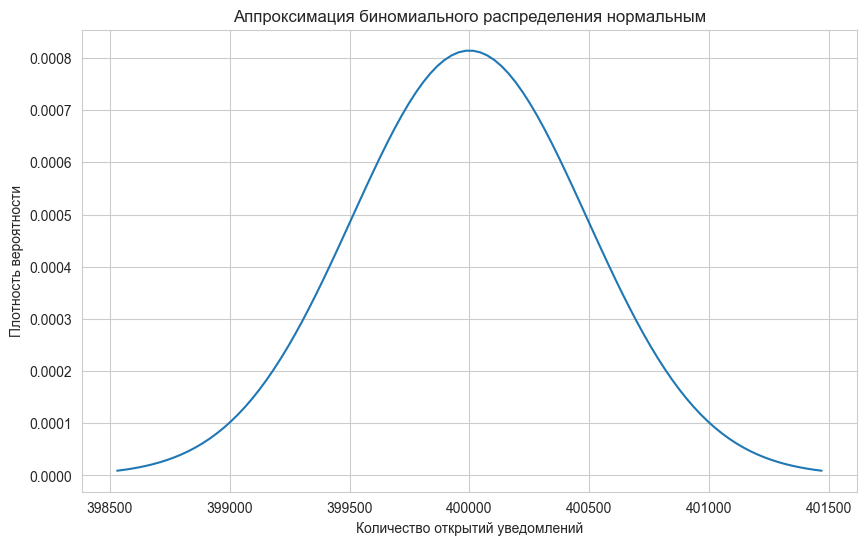

In [38]:
n = 1000000
p = 0.4

mu = n * p
sigma = (n * p * (1 - p))**0.5

distr = st.norm(mu, sigma)

x_values = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
y_values = distr.pdf(x_values)
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.title('Аппроксимация биномиального распределения нормальным')
plt.xlabel('Количество открытий уведомлений')
plt.ylabel('Плотность вероятности')
plt.grid(True);

In [39]:
result = distr.cdf(399500)
print(f'Вывод: вероятность, что уведомление откроют менее 399,5 тыс. пользователей - {result:.2%}.')

Вывод: вероятность, что уведомление откроют менее 399,5 тыс. пользователей - 15.37%.
